<a href="https://colab.research.google.com/github/ananthapadmanabhan-o/satellite_image_segmentation/blob/main/semantic_segmentation_aerial_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install patchify
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2,

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import random
import tensorflow as tf

random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
data_folder = '/content/drive/MyDrive/semantic_segmentation_aerial_image/data'

In [6]:
# for path, subdirs, files in os.walk(data_folder):
#     dir_name = path.split(os.path.sep)[-1]
#     if dir_name == 'masks':
#         images = os.listdir(path)
#         print('='*50)
#         print(path)
#         print(images)
#     for i,img_file in enumerate(images):
#         if img_file.endswith('.png'):
#             print(os.path.join(path,img_file))

In [7]:
# data_path = 'data'
# for folder in next(os.walk(data_path))[1]:
#     folder_path = os.path.join(data_path,folder)
#     for sub_folder in os.listdir(folder_path):
#         sub_folder_path = os.path.join(data_path,folder,sub_folder)
#         print(os.listdir(sub_folder_path))

In [8]:
patch_size = 256

scaler = MinMaxScaler()

In [9]:
image_dataset = []
mask_dataset = []


for image_type in tqdm(['images','masks']):
    if image_type == 'images':
        extension = 'jpg'
    elif image_type == 'masks':
        extension = 'png'

    for tile_id in range(1,8):
        for image_id in range(1,10):
            image = cv2.imread(f'{data_folder}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{extension}',1)
            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                size_y = (image.shape[0]//patch_size)*patch_size
                size_x = (image.shape[1]//patch_size)*patch_size
                image = Image.fromarray(image).crop((0,0,size_x,size_y))
                image = np.array(image)
                patched_images = patchify(image,(patch_size,patch_size,3),step=patch_size)

                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == 'images':
                            individual_patched_image = patched_images[i,j,:,:]
                            #print(individual_patched_image.shape)
                            individual_patched_image = scaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            #print(individual_patched_image.shape)
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = patched_images[i,j,:,:]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

100%|██████████| 2/2 [00:18<00:00,  9.02s/it]


In [10]:
len(image_dataset),len(mask_dataset)

(945, 945)

In [11]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [12]:
image_dataset.shape

(945, 256, 256, 3)

In [13]:
image_dataset[0].shape

(256, 256, 3)

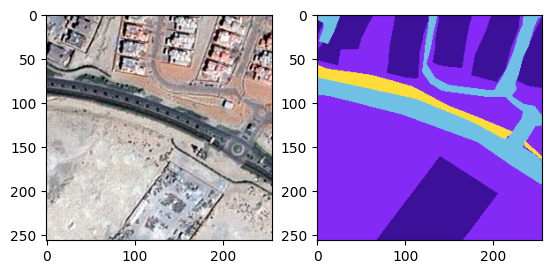

In [14]:
num = random.randint(0,len(image_dataset))
# num = 0
fig,ax = plt.subplots(1,2)
ax[0].imshow(image_dataset[num])
ax[1].imshow(mask_dataset[num])

In [15]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [16]:

def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
    label_segment = label_segment[:,:,0]
    return label_segment

In [17]:
labels = []

for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

In [18]:
labels = np.array(labels)
labels = np.expand_dims(labels,axis=3)

In [19]:
labels.shape

(945, 256, 256, 1)

In [20]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [21]:
labels[0].shape

(256, 256, 1)

In [22]:
labels[0][0].shape

(256, 1)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
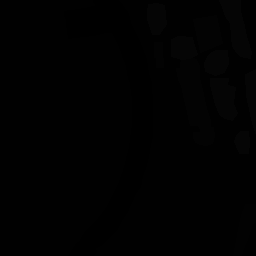

In [23]:
labels[0][:,:,0]

In [24]:
labels[0][:,:,0].shape

(256, 256)

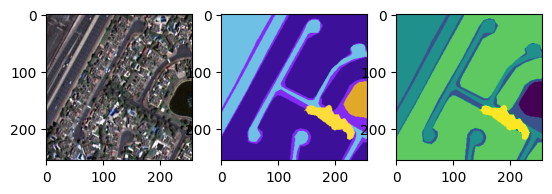

In [25]:
num = random.randint(1,len(mask_dataset))
fig, ax = plt.subplots(1,3)
ax[0].imshow(image_dataset[num])
ax[1].imshow(mask_dataset[num])
ax[2].imshow(labels[num])

In [26]:
mask_dataset

array([[[[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        ...,

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
        

In [27]:
from keras.utils import to_categorical

total_classes = len(np.unique(labels))

labels_categorical_dataset = to_categorical(labels,num_classes=total_classes)

In [28]:
labels_categorical_dataset

array([[[[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        ...,

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0.

In [29]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(image_dataset,labels_categorical_dataset,test_size=0.1,random_state=42)

In [30]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(850, 256, 256, 3)
(95, 256, 256, 3)
(850, 256, 256, 6)
(95, 256, 256, 6)


In [31]:
import keras.backend as K

def jaccard_coef(y_true,y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten*y_pred_flatten)
  final_coef_value = intersection / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection)
  return final_coef_value

In [32]:
def unet_model(n_classes = 6,image_height = 256, image_width = 256, image_channel = 3):

  inputs = tf.keras.layers.Input((image_height,image_width,image_channel))


  #########################################################################################################

  c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
  #########################################################################################################

  c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
  #########################################################################################################

  c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.1)(c3)
  c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
  #########################################################################################################

  c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.1)(c4)
  c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
  #########################################################################################################

  c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.1)(c5)
  c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
  #########################################################################################################


  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  #########################################################################################################

  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  #########################################################################################################

  u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides = (2,2),padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
  #########################################################################################################

  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
  #########################################################################################################

  outputs = tf.keras.layers.Conv2D(n_classes,(1,1),activation='softmax')(c9)
  #########################################################################################################

  model = tf.keras.Model(inputs=[inputs],outputs=[outputs])

  return model




In [33]:
metrics = ['accuracy',jaccard_coef]


def get_deep_learning_model():
  return unet_model(n_classes = 6,
                    image_height=256,
                    image_width=256,
                    image_channel=3)

In [34]:
model = get_deep_learning_model()

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [36]:
model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': N

In [37]:
! pip install -U segmentation-models


In [38]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]


In [39]:
import segmentation_models as sm


dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


In [40]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [44]:
with tf.device('GPU'):
  model_history = model.fit(x_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(x_test, y_test),
                          shuffle=False)

Epoch 1/100
54/54 [==============================] - 42s 339ms/step - loss: 0.9990 - accuracy: 0.5439 - jaccard_coef: 0.2646 - val_loss: 0.9823 - val_accuracy: 0.5882 - val_jaccard_coef: 0.3413
Epoch 2/100
54/54 [==============================] - 11s 205ms/step - loss: 0.9750 - accuracy: 0.6698 - jaccard_coef: 0.3804 - val_loss: 0.9682 - val_accuracy: 0.7253 - val_jaccard_coef: 0.4511
Epoch 3/100
54/54 [==============================] - 11s 210ms/step - loss: 0.9609 - accuracy: 0.7199 - jaccard_coef: 0.4549 - val_loss: 0.9586 - val_accuracy: 0.7348 - val_jaccard_coef: 0.4768
Epoch 4/100
54/54 [==============================] - 11s 206ms/step - loss: 0.9525 - accuracy: 0.7468 - jaccard_coef: 0.4987 - val_loss: 0.9488 - val_accuracy: 0.7688 - val_jaccard_coef: 0.5265
Epoch 5/100
54/54 [==============================] - 11s 206ms/step - loss: 0.9483 - accuracy: 0.7568 - jaccard_coef: 0.5126 - val_loss: 0.9445 - val_accuracy: 0.7725 - val_jaccard_coef: 0.5254
Epoch 6/100
54/54 [===========

In [43]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [46]:
model.save('image_segmentation.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
model_history.history

{'loss': [0.998996913433075,
  0.974974513053894,
  0.9609199166297913,
  0.9525143504142761,
  0.9483422636985779,
  0.9458938241004944,
  0.9432805180549622,
  0.9412681460380554,
  0.9404497742652893,
  0.9357033967971802,
  0.9326666593551636,
  0.9309266805648804,
  0.9291386008262634,
  0.9266458749771118,
  0.9237193465232849,
  0.9233818650245667,
  0.9232451915740967,
  0.9245333075523376,
  0.9193056225776672,
  0.9175909161567688,
  0.9164187908172607,
  0.9147377610206604,
  0.9138019680976868,
  0.9122482538223267,
  0.9129959940910339,
  0.9134882688522339,
  0.9106616377830505,
  0.909035861492157,
  0.908065676689148,
  0.9084897041320801,
  0.9066775441169739,
  0.906658411026001,
  0.9084263443946838,
  0.9052513837814331,
  0.9046756029129028,
  0.9045298099517822,
  0.9040625691413879,
  0.9032726287841797,
  0.9005593061447144,
  0.8989058136940002,
  0.8987858891487122,
  0.8982416391372681,
  0.8974785208702087,
  0.8990620970726013,
  0.8987957835197449,
  0.897

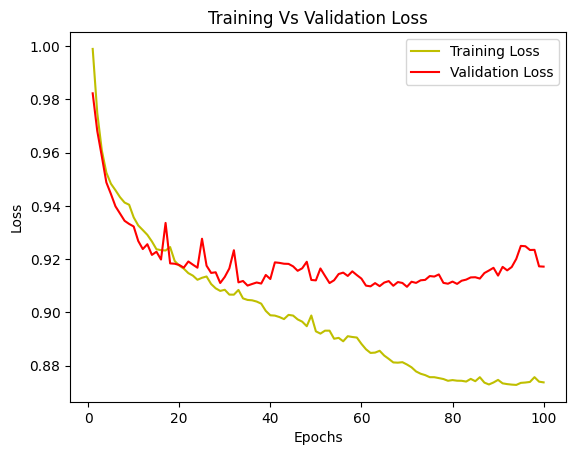

In [49]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

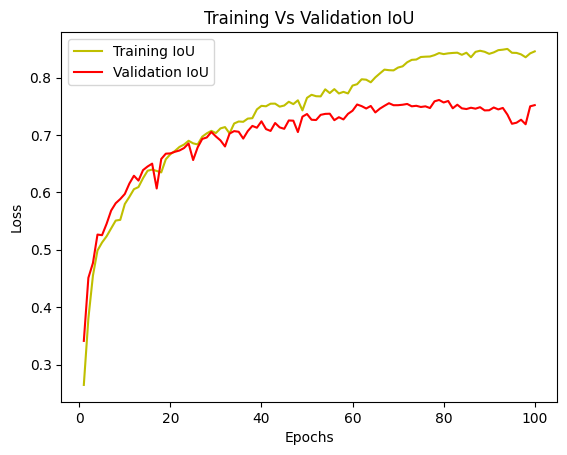

In [50]:
jaccard_coef = model_history.history['jaccard_coef']
val_jaccard_coef = model_history.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [52]:
with tf.device('GPU'):
  y_pred = model.predict(x_test)


3/3 [==============================] - 9s 2s/step


In [54]:
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)


In [65]:
test_image_number = random.randint(0, len(x_test))

test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 23ms/step


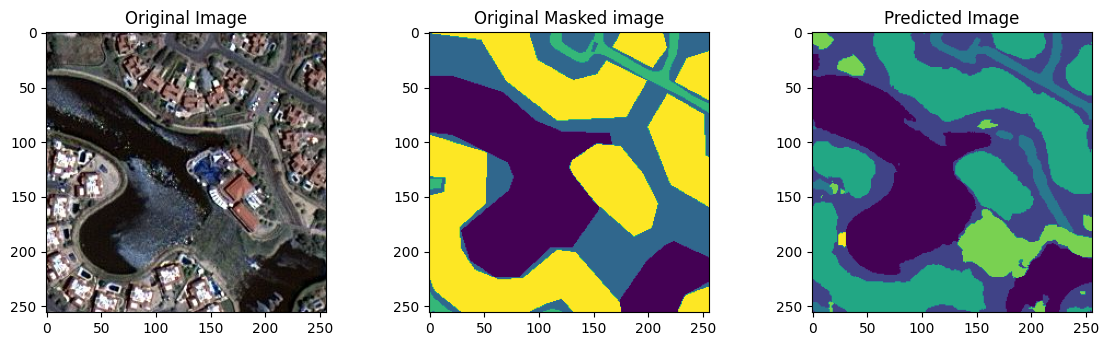

In [66]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)
